# Librerias

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# import matplotlib.pyplot as plt
import numpy as np
import os
#
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# SAVE_PATH = "" #Local
SAVE_PATH = "/content/gdrive/MyDrive/VGG"

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo

In [ ]:
class EncoderVGG16(nn.Module):
    def __init__(self,
                 n_layers = 5,
                 h_dims = [512,256,128,10]):
        super(EncoderVGG16,self).__init__()
        self.n_layers = n_layers
        self.h_dims = h_dims
        self.layers = [4,9,16,23,31]
        self.full_vgg16 = torchvision.models.vgg16()
        self.vgg = self.full_vgg16.features[:self.layers[self.n_layers-1]]
        self.classifier = self.full_vgg16.classifier

        self.classifier[0] = nn.Linear(self.h_dims[0], self.h_dims[1])
        self.classifier[3] = nn.Linear(self.h_dims[1], self.h_dims[2])
        self.classifier[6] = nn.Linear(self.h_dims[2], self.h_dims[3])

    def encode(self,x):
        return self.vgg(x)

    def forward(self,x):
        latent = self.encode(x)
        latent = torch.flatten(latent,start_dim = 1)
        output = self.classifier(latent)
        return output

In [ ]:
model = EncoderVGG16()
# model.vgg, model.classifier

In [ ]:
model

EncoderVGG16(
  (full_vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
  

# Dataset

In [ ]:
if not os.path.exists("data"):
    os.makedirs("data")
    print("Data directory created :D")

if not os.path.exists("data/train"):
    os.makedirs("data/train")
    print("Data train directory created :D")

if not os.path.exists("data/val"):
    os.makedirs("data/val")
    print("Data val directory created :D")


In [6]:
final_save = os.path.join(SAVE_PATH,"clean_params")
# if not os.path.exists(final_save):
#     os.makedirs(final_save)
#     print("Data directory created :D")


In [ ]:
# from corrupter import *

In [ ]:
transform = transforms.Compose([
     # transforms.Resize(size=(224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    #  transforms.Lambda(gaussian_pixels)
     ])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root = "data/train/",train=True, transform= transform,download=True)
val_dataset = torchvision.datasets.CIFAR10(root = "data/val/",train = False, transform= transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


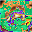

In [ ]:
train_image_zero, train_target_zero =train_dataset[0]
transforms.ToPILImage()(train_image_zero)

In [ ]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/train/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
val_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/val/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

# DataLoaders y criterios de optimización

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=1000,shuffle=True,)
valloader = DataLoader(val_dataset,batch_size= 1000,shuffle= False)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.005, weight_decay= 1e-6)

# Entrenamiento

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, cuda):

    total = 0
    correct = 0
    train_loss = 0

    model.train()
    for i, data in enumerate(train_loader):
        if i % 100 == 0:
            print(f"Batch {i}/{len(train_loader)}")

        inputs, labels = data

        if cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()
    accuracy = correct/total
    train_loss /= len(train_loader)
    return train_loss, accuracy

def validate(model, val_loader, criterion, cuda):

    correct = 0
    val_loss = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for data in val_loader:

            inputs, labels = data

            if cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)

            loss = criterion(outputs,labels)
            _, predicted = torch.max(outputs.data, 1)


            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    val_loss /= len(val_loader)
    accuracy = correct/total
    return val_loss, accuracy

In [ ]:
def training(model,
             epochs,
             train_loader,
             val_loader,
             criterion,
             optimizer,
             each = 50,
             state = None,
             name = "",
             cuda = True):

    # If trained before
    if state == None:
        state = {
            "epoch" : 0,
            "loss" : [[], []], # [train, val]
            "acc" : [[], []], # [train, val]
            "params" : None,
            "bestloss" : np.inf
        }

    # If previously trained
    else:
        state = torch.load(state)
        model.load_state_dict(state["params"])

    best_loss = state["bestloss"]
    state_epochs = state["epoch"]

    if cuda:
        model = model.cuda()

    for epoch in range(state_epochs, state_epochs + epochs):
        print(f"Epoch nro {epoch + 1}/{epochs}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, cuda)
        # Val
        val_loss, val_acc = validate(model, val_loader,criterion, cuda)

        print(f"Train loss = {train_loss}, Val loss = {val_loss}")
        print(f"Train acc = {train_acc}, Val acc = {val_acc}")
        # print(f"Val acc = {val_acc}")

        if (best_loss > val_loss):
            best_loss = val_loss
            print(f"Better params found in epoch = {epoch + 1}, saved params")
            torch.save(model.state_dict(), os.path.join(final_save,f'bestVGGParams{name}.pt'))
        # Load best model so far to proceed

        # Save periodically for each
        if ((epoch + 1)%each == 0):
            print(f"Se ha guardado la época múltiplo de {each}")
            torch.save(model.state_dict(), os.path.join(final_save,f'eachVGGParams_{epoch + 1}.pt'))

        # Update state
        state["loss"][0].append(train_loss)
        state["loss"][1].append(val_loss)
        state["acc"][0].append(train_acc)
        state["acc"][1].append(val_acc)
        state["epoch"] = epoch + 1
        state["params"] = model.state_dict()
        state["bestloss"] = best_loss

        # Save per epoch just in case
        torch.save(state, os.path.join(final_save,f"VGG_{epoch + 1}.pt"))
    return state["loss"]

In [ ]:
state_dir = os.path.join(final_save,f"VGG_{<LAST>}")

In [ ]:
train_state = training(model = model,
                     epochs = 100,
                     train_loader = trainloader,
                     val_loader = valloader,
                     criterion = criterion,
                     optimizer = optimizer,
                     each = 2,
                     state = None, #If trained state_dir
                     name = "Clean",
                     cuda = True,)

Epoch nro 1/100
Batch 0/50


KeyboardInterrupt: ignored